In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import torch.nn as nn
from transformers import BertModel
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import json 
import torch 
import random 
from ray.data.preprocessor import Preprocessor
#from ray.train.torch import get_device 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
import numpy as np
import os
import ray 
import logging
logging.getLogger('ray').setLevel(logging.ERROR)

In [118]:
from ray.air import  session
from ray.train import Checkpoints
from ray.air.config import CheckpointConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

TypeError: NoneType takes no arguments

In [44]:
import ray
if ray.is_initialized():
    ray.shutdown()
ray.init(
    log_to_driver=False,
    _metrics_export_port=None
)
import sys
sys.path.append("..")

2025-12-14 17:44:25,728	INFO worker.py:2023 -- Started a local Ray instance.
2025-12-14 17:44:25,777	INFO packaging.py:588 -- Creating a file package for local module '/Users/aravindrajeshmenon/Documents/DataScienceProjects/Projects/reddit_nlp_classification'.
2025-12-14 17:44:25,808	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_a88924be3e82b8d2.zip' (2.78MiB) to Ray cluster...
2025-12-14 17:44:25,812	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_a88924be3e82b8d2.zip'.


In [45]:
ray.cluster_resources()

{'object_store_memory': 1612269158.0,
 'CPU': 8.0,
 'node:__internal_head__': 1.0,
 'node:127.0.0.1': 1.0,
 'memory': 3761961370.0}

In [4]:
num_workers = 6 
resources_per_worker={"CPU": 1, "GPU": 0}

In [7]:
DATASET_LOC = os.path.join(os.getcwd(), 'data', 'reddit_posts_20251212_035106.parquet')

In [8]:
df = pd.read_parquet(DATASET_LOC)

In [9]:
df.head()

,post_id,title,subreddit
0,1pkhhxb,"Even the man behind ChatGPT, OpenAI CEO Sam Al...",technology
1,1pkh69t,"Palantir sues CEO of rival AI firm Percepta, a...",technology
2,1pkg053,'Architects of AI' named Time Magazine's Perso...,technology
3,1pkfqa0,Sam Altman expects OpenAI to exit ‘code red’ b...,technology
4,1pkfpmf,Broadcom reveals its mystery $10 billion custo...,technology


In [10]:
df['subreddit'].value_counts()

subreddit
entertainment            997
technology               989
science                  987
politics                 986
ArtificialInteligence    962
Name: count, dtype: int64

In [11]:
df = df.sample(frac = 1.0)

In [12]:
test_size = 0.2 
train_df, val_df = train_test_split(df, test_size = test_size, stratify = df['subreddit'], random_state = 13)
                                    

In [13]:
train_df['subreddit'].value_counts()

subreddit
entertainment            797
technology               791
politics                 789
science                  789
ArtificialInteligence    770
Name: count, dtype: int64

In [14]:
(val_df['subreddit'].value_counts() * (1-test_size))/(test_size)

subreddit
entertainment            800.0
science                  792.0
technology               792.0
politics                 788.0
ArtificialInteligence    768.0
Name: count, dtype: float64

## EDA 

Let us first visualise the number of examples per subreddit. 

In [15]:
counter = Counter(df['subreddit'])
counter.most_common()

[('entertainment', 997),
 ('technology', 989),
 ('science', 987),
 ('politics', 986),
 ('ArtificialInteligence', 962)]

(pid=gcs_server) [2025-12-14 17:24:39,017 E 32829 4932192] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


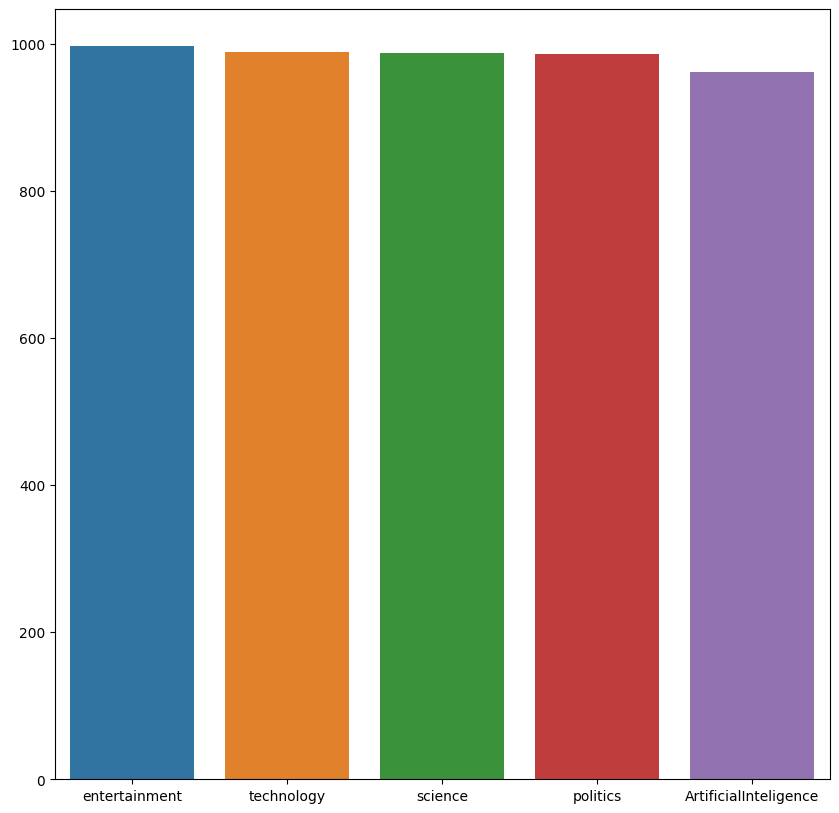

In [16]:
subreddit, counts = zip(*counter.most_common())
plt.figure(figsize = (10,10))
sns.barplot(x = list(subreddit), y = list(counts), hue = list(subreddit))
plt.show()

In [17]:
subreddits = df['subreddit'].unique().tolist()

(raylet) [2025-12-14 17:24:41,707 E 32833 4932305] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(pid=32844) [2025-12-14 17:24:44,396 E 32844 4932700] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-14 17:24:44,521 E 32819 4932442] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


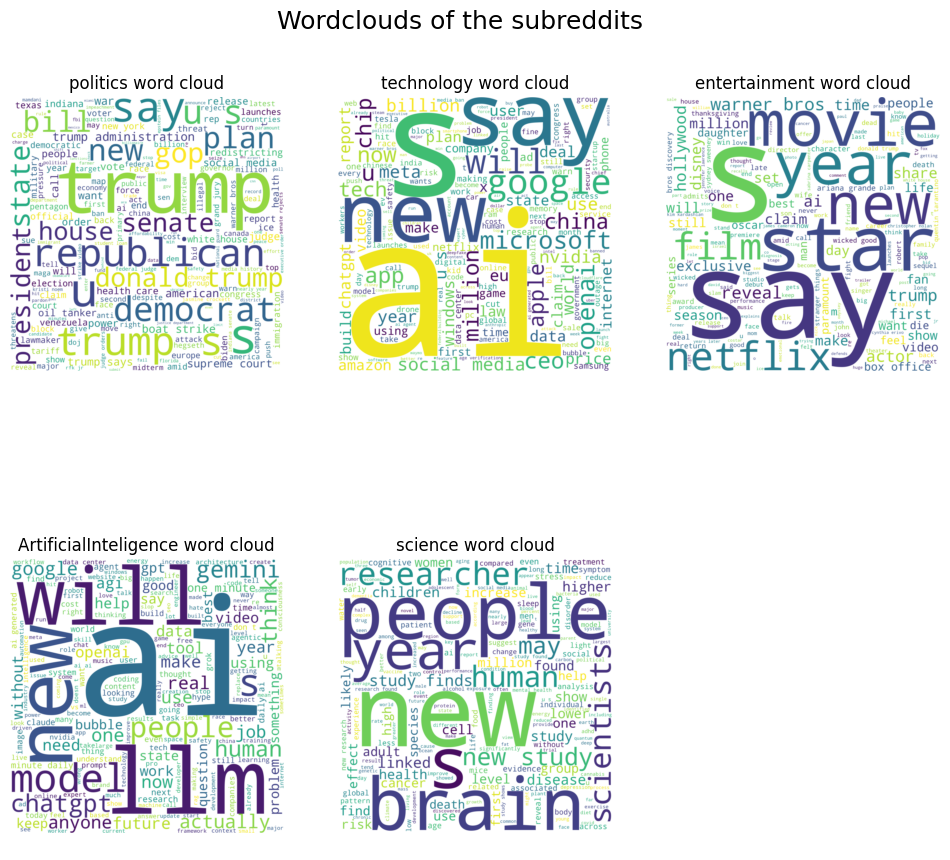

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Wordclouds of the subreddits", fontsize=18, y=0.95)

for sub, ax in zip(subreddits, axs.ravel()):
    stopwords = set(STOPWORDS)
    text = ' '.join(df[df['subreddit'] == sub]['title'].astype('str').tolist())
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    wordcloud = WordCloud(width=2000, height=2000, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sub} word cloud")
    ax.axis('off')

axs.ravel()[-1].axis('off')

plt.show()
        

In [19]:
def clean_text(text):
    stopwords = set(STOPWORDS)
    text = text.lower()
 
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text) 
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = text.strip()
    text = re.sub(r"http\S+", "", text)
    return text 
    

In [20]:
original_df = df.copy()
df['title'] = df['title'].map(clean_text)

In [21]:
print(original_df['title'][0])
print(df['title'][0])

Even the man behind ChatGPT, OpenAI CEO Sam Altman is worried about the ‘rate of change that’s happening in the world right now’ thanks to AI
even man behind chatgpt openai ceo sam altman worried rate change s happening world right now thanks ai


In [22]:
df = df.drop(columns = ['post_id'], axis = 1) 
df = df.dropna()

In [23]:
class_to_index = {k:i for i, k in enumerate(subreddits)}
class_to_index

{'politics': 0,
 'technology': 1,
 'entertainment': 2,
 'ArtificialInteligence': 3,
 'science': 4}

In [24]:
index_to_class = {v:k for k,v in class_to_index.items()}
index_to_class

{0: 'politics',
 1: 'technology',
 2: 'entertainment',
 3: 'ArtificialInteligence',
 4: 'science'}

In [25]:
def encode(indices, class_to_index):
    return [class_to_index[index] for index in indices]


In [26]:
encode(df.sample(5)["subreddit"].values, class_to_index=class_to_index)

[0, 2, 4, 4, 1]

In [27]:
df['subreddit'] = df['subreddit'].map(class_to_index)

In [28]:
df

,title,subreddit
4730,jd vance s hedging presidential run imperil ca...,0
370,cloudflare says fended 416 billion ai bot scra...,1
2216,connie chung blasts cbs greedy owners says cau...,2
3309,comes dead internet,3
2563,gal gadot recalls diagnosed massive blood clot...,2
...,...,...
2117,5 media pacts signed putin launches rt india,2
2986,automate routine monotonous tender downloading...,3
2076,unions industry groups assemble fight netflix ...,2
3072,sometimes feel chatgpt 5 1 instant dumb,3


In [29]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [30]:
decode(df.head()["subreddit"].values, index_to_class=index_to_class)

['politics',
 'technology',
 'entertainment',
 'ArtificialInteligence',
 'entertainment']

In [63]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

In [93]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch['title'].tolist(), padding = 'longest',return_tensors = 'pt')
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["subreddit"]))

In [92]:
def preprocess(df, class_to_index:dict):
    df['title'] = df['title'].map(clean_text)
    df = df.drop(columns = ['post_id'], axis = 1) 
    df = df.dropna()
    df['subreddit'] = df['subreddit'].map(class_to_index)
    outputs = tokenize(df)
    return outputs
    

In [33]:
train_inputs = preprocess(train_df, class_to_index)
val_inputs = preprocess(val_df, class_to_index)

In [46]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [47]:
ds = ray.data.read_parquet(DATASET_LOC)
ds = ds.random_shuffle(seed= 43)
ds.take(1)

Parquet dataset sampling 0:   0%|                                                                             …

[2025-12-14 17:44:57,970 E 32819 4949044] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-12-14 17:45:05,957	INFO parquet_datasource.py:728 -- Estimated parquet encoding ratio is 1.475.
2025-12-14 17:45:05,958	INFO parquet_datasource.py:788 -- Estimated parquet reader batch size at 1082402 rows
2025-12-14 17:45:09,207	INFO logging.py:397 -- Registered dataset logger for dataset dataset_2_0
2025-12-14 17:45:09,216	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2025-12-14_17-44-23_772319_32819/logs/ray-data
2025-12-14 17:45:09,217	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_2_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- limit=1 5: 0.00 row [00:00, ? row/s]

2025-12-14 17:45:09,896	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_2_0 execution finished in 0.67 seconds
2025-12-14 17:45:09,942	INFO util.py:257 -- Exiting prefetcher's background thread


[{'post_id': '1p6zlkq',
  'title': 'AI optimized content',
  'subreddit': 'ArtificialInteligence'}]

In [48]:
train_ds, val_ds = ds.train_test_split(test_size = 0.2, seed = 43)

2025-12-14 17:46:50,279	INFO logging.py:397 -- Registered dataset logger for dataset dataset_3_0
2025-12-14 17:46:50,299	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2025-12-14_17-44-23_772319_32819/logs/ray-data
2025-12-14 17:46:50,301	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> TaskPoolMapOperator[Project] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|                                                                                              …

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- Project 5: 0.00 row [00:00, ? row/s]

- AggregateNumRows 6:   0%|                                                                                   …

2025-12-14 17:46:51,980	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_3_0 execution finished in 1.68 seconds
2025-12-14 17:46:51,994	INFO util.py:257 -- Exiting prefetcher's background thread
2025-12-14 17:46:52,008	INFO logging.py:397 -- Registered dataset logger for dataset dataset_1_0
2025-12-14 17:46:52,019	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2025-12-14_17-44-23_772319_32819/logs/ray-data
2025-12-14 17:46:52,020	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

2025-12-14 17:46:52,229	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_1_0 execution finished in 0.21 seconds


In [49]:
sample_ds = train_ds.map_batches(preprocess, batch_format = 'pandas', fn_kwargs = {'class_to_index' : class_to_index})

In [50]:
sample_ds.take(1)

2025-12-14 17:52:45,759	INFO logging.py:397 -- Registered dataset logger for dataset dataset_7_0
2025-12-14 17:52:45,769	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2025-12-14_17-44-23_772319_32819/logs/ray-data
2025-12-14 17:52:45,770	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

- MapBatches(preprocess) 2: 0.00 row [00:00, ? row/s]

2025-12-14 17:53:25,619	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_7_0 execution finished in 39.84 seconds
2025-12-14 17:53:25,635	INFO util.py:257 -- Exiting prefetcher's background thread


[{'ids': array([ 102, 4725, 7150, 2118,  103]),
  'masks': array([1, 1, 1, 1, 1]),
  'targets': 3}]

In [52]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [57]:
def load_dataset(num_samples = None):
    ds = ray.data.load_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed = 43)
    ds = ray.data.from_items(ds.take(num_sample) if num_samples else ds)
    return ds 

In [58]:
class CustomPreprocessor(Preprocessor):
    def _fit(self, ds):
        subs = ds.unique(column = 'subreddit')
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):
        return preprocess(batch, class_to_index = self.class_to_index)
    

In [60]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [61]:
embedding_dim

768

In [82]:
text = ["Transfer learning with transformers for text classification.", "i hate ai. it really sucks", "man f this"]
batch = tokenizer(text, return_tensors="pt", padding="longest")
print(batch)
#batch = {k:torch.tensor(v) for k,v in batch.items()}
#print(batch)
result = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
seq, pool = result

{'input_ids': tensor([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,   103,
             0],
        [  102,   259,  6500, 30107,  4725,   205,   256,  9695,  1639,   784,
           103],
        [  102,   508,   125,   238,   103,     0,     0,     0,     0,     0,
             0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


In [98]:
class FineTunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FineTunedLLM,self).__init__()
        self.llm = llm 
        self.dropout_p = nn.Dropout(p = dropout_p)
        self.embedding_dim = llm.config.hidden_size
        self.fc1 = nn.Linear(self.embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = llm(input_ids = ids, attention_mask = masks)
        pool = self.dropout(pool)
        outputs = self.fc1(pool)
        return outputs
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)   ### -> automatically does forward layer logic onto the inputs
        y_pred = torch.argmax(z, dim = 1).cpu().numpy()
        return y_pred
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(inputs)
        z = nn.Softmax(z, dim = 1).cpu().numpy()
        return z
        
        
        
        

In [99]:
model = FineTunedLLM(llm, dropout_p = 0.5, embedding_dim = embedding_dim, num_classes = len(subreddits))

In [102]:
model.named_parameters

<bound method Module.named_parameters of FineTunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [106]:
def pad_array(arrs, dtype = np.int32):
    max_len = max(len(arr) for arr in arrs)
    padded_arr = np.zeros((arrs.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arrs):
        padded_arr[i][:len(row)] = row
    return padded_arr    
        

In [110]:
def collate_fn(batch):
    batch['ids'] = pad_array(batch['ids'])
    batch['masks'] = pad_array(batch['masks'])
    target_batch = {'ids' : torch.int32, 'masks' : torch.int32, 'targets' : torch.int32}
    tensor_batch = {}
    for key, item in batch.items():
        tensor_batch[key] = torch.as_tensor(item, dtype = target_batch[key])

    return tensor_batch    

In [111]:
collate_fn(sample_ds.take_batch(batch_size = 128))

2025-12-18 08:34:45,297	INFO logging.py:397 -- Registered dataset logger for dataset dataset_10_0
2025-12-18 08:34:45,307	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_10_0. Full logs are in /tmp/ray/session_2025-12-14_17-44-23_772319_32819/logs/ray-data
2025-12-18 08:34:45,307	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_10_0: InputDataBuffer[Input] -> LimitOperator[limit=128] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- limit=128 1: 0.00 row [00:00, ? row/s]

- MapBatches(preprocess) 2: 0.00 row [00:00, ? row/s]

2025-12-18 08:34:46,057	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_10_0 execution finished in 0.75 seconds


{'ids': tensor([[  102,  4725,  7150,  ...,     0,     0,     0],
         [  102,   758, 27765,  ...,     0,     0,     0],
         [  102,  1641,   122,  ...,     0,     0,     0],
         ...,
         [  102,   265,  3927,  ...,     0,     0,     0],
         [  102, 10467, 22441,  ...,     0,     0,     0],
         [  102, 15557, 17327,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([3, 2, 2, 3, 4, 2, 4, 2, 2, 3, 1, 1, 1, 3, 2, 3, 2, 1, 1, 2, 0, 4, 2, 2,
         3, 3, 4, 1, 4, 0, 0, 3, 2, 4, 3, 1, 2, 3, 4, 0, 2, 3, 3, 4, 0, 4, 0, 3,
         3, 4, 4, 1, 1, 3, 2, 2, 0, 0, 3, 4, 1, 4, 3, 1, 1, 0, 2, 4, 2, 0, 1, 1,
         0, 3, 4, 0, 4, 4, 4, 2, 1, 3, 0, 4, 1, 0, 2, 4, 4, 2, 0, 0, 3, 4, 2, 2,
         3, 0, 